In [1]:
%load_ext autoreload
%autoreload 2

from huggingface_hub import hf_hub_download
import torch
from moshi.models import loaders, LMGen
from moshi.models.lm import LMNoStream

import sentencepiece
import torchaudio

from IPython.display import Audio as display_audio



/opt/conda/envs/moshi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Mimi

In [2]:
mimi_weight = hf_hub_download(loaders.DEFAULT_REPO, loaders.MIMI_NAME)
mimi = loaders.get_mimi(mimi_weight, device='cpu')
mimi.set_num_codebooks(8)  # up to 32 for mimi, but limited to 8 for moshi.

wav = torch.randn(1, 1, 24000 * 10)  # should be [B, C=1, T]
with torch.no_grad():
    codes_no_stream = mimi.encode(wav)  # [B, K = 8, T]
    decoded_no_stream = mimi.decode(codes_no_stream)

    # Supports streaming too.
    frame_size = int(mimi.sample_rate / mimi.frame_rate)
    all_codes = []
    with mimi.streaming(batch_size=1):
        for offset in range(0, wav.shape[-1], frame_size):
            frame = wav[:, :, offset: offset + frame_size]
            codes = mimi.encode(frame)
            assert codes.shape[-1] == 1, codes.shape
            all_codes.append(codes)
            

In [3]:
# One-off and streaming should be the same.
torch.allclose(
    torch.stack(all_codes).reshape(-1,8),
    codes_no_stream.reshape(8,-1).T)

True

In [4]:
display_audio(decoded_no_stream[0].cpu().numpy(), rate=mimi.sample_rate)

### Moshi

#### Example from readme

In [3]:
mimi.cuda()
moshi_weight = hf_hub_download(loaders.DEFAULT_REPO, loaders.MOSHI_NAME)
moshi = loaders.get_moshi_lm(moshi_weight, device='cuda')
lm_gen = LMGen(moshi, temp=0.8, temp_text=0.7)  # this handles sampling params etc.


In [2]:
out_wav_chunks = []
out_text_chunks = []
# Now we will stream over both Moshi I/O, and decode on the fly with Mimi.
with torch.no_grad(), lm_gen.streaming(1), mimi.streaming(1):
    for idx, code in enumerate(all_codes):
        tokens_out = lm_gen.step(code.cuda())
        # tokens_out is [B, 1 + 8, 1], with tokens_out[:, 0] representing the text token.
        if tokens_out is not None:
            wav_chunk = mimi.decode(tokens_out[:, 1:])
            out_wav_chunks.append(wav_chunk)
            out_text_chunks.append(tokens_out[:, 0])
        print(idx, end='\r')
out_wav = torch.cat(out_wav_chunks, dim=-1)

NameError: name 'lm_gen' is not defined

In [3]:
display_audio(out_wav.cpu().numpy().reshape(-1,), rate=mimi.sample_rate)
torchaudio.save('moshi_mimi.wav', out_wav.cpu().reshape(1, -1), mimi.sample_rate)

NameError: name 'display_audio' is not defined

In [4]:
args_tokenizer = hf_hub_download(loaders.DEFAULT_REPO, loaders.TEXT_TOKENIZER_NAME)
text_tokenizer = sentencepiece.SentencePieceProcessor(args_tokenizer)

text_tokens = torch.stack(out_text_chunks).reshape(-1).tolist()
" ".join(text_tokenizer.id_to_piece(text_tokens))



NameError: name 'sentencepiece' is not defined

#### Now try with a user input

In [9]:
user_input = torchaudio.load('moshi_mimi.wav')[0].reshape(1,1,-1).cuda()
user_input = mimi.encode(user_input)
user_input = user_input.reshape(8, -1).T.reshape(-1, 1, 8, 1)

# Add some additional silence to the beginning

In [13]:
out_wav_chunks = []
out_text_chunks = []
# Now we will stream over both Moshi I/O, and decode on the fly with Mimi.
with torch.no_grad(), lm_gen.streaming(1), mimi.streaming(1):
    for idx, code in enumerate(user_input):
        tokens_out = lm_gen.step(code.cuda())
        # tokens_out is [B, 1 + 8, 1], with tokens_out[:, 0] representing the text token.
        if tokens_out is not None:
            wav_chunk = mimi.decode(tokens_out[:, 1:])
            out_wav_chunks.append(wav_chunk)
            out_text_chunks.append(tokens_out[:, 0])
        print(idx, end='\r')
out_wav = torch.cat(out_wav_chunks, dim=-1)

In [14]:
display_audio(out_wav.cpu().numpy().reshape(-1,), rate=mimi.sample_rate)

### Explore streaming

What is the input to `lm_gen.step` doing? In the original code above it uses just random inputs?
* Below we replaced them by 0 and it still works properly
* Current hypothesis: this is used as the input from the user (but not the generated outputs)
  * This is backed up `needed_tokens` = 17 - 8 - 1


How does the model properly continue a sequence? Is it via the streaming state?
* The generated outputs are saved via the kv cache
* But how is the full input sequence stored? The internal state has only as "seq. length" of 3?!

What is the "external streaming state" exactly tracking? Why is it needed if we have the "internal" KV cache?
* I partially tracks the input stream from the user (the last 8 codebook entries).
* But why is it also tracking the output stream?

Why is the stream CT only 3?
* Is this the only place where we store input tokens?
* How is the full input sequence accessed?

#### Explore variables and states

#### Check all streaming states

In [4]:
out_wav_chunks = []
out_text_chunks = []
streaming_states = []
transformer_streaming_states = []
layer_streaming_states = []
attention_stremaing_states = []
# Now we will stream over both Moshi I/O, and decode on the fly with Mimi.
with torch.no_grad(), lm_gen.streaming(1), mimi.streaming(1):
    for idx in range(10):
        # tokens_out = lm_gen.step(code.cuda())
        tokens_out = lm_gen.step(torch.zeros(1, 8, 1, dtype=torch.int32).cuda() + 1)
        # tokens_out is [B, 1 + 8, 1], with tokens_out[:, 0] representing the text token.
        if tokens_out is not None:
            wav_chunk = mimi.decode(tokens_out[:, 1:])
            out_wav_chunks.append(wav_chunk)
            out_text_chunks.append(tokens_out[:, 0])
        print(idx, end='\r')

        streaming_states.append(lm_gen._streaming_state.cache.detach().clone())
        transformer_streaming_states.append(lm_gen.lm_model.transformer._streaming_state)
        layer_streaming_states.append(lm_gen.lm_model.transformer.layers[0]._streaming_state)
        attention_stremaing_states.append(lm_gen.lm_model.transformer.layers[0].self_attn._streaming_state)
out_wav = torch.cat(out_wav_chunks, dim=-1)

NameError: name 'lm_gen' is not defined

In [11]:
streaming_states[8]

NameError: name 'streaming_states' is not defined

In [18]:
transformer_streaming_states[1]

_TransformerState(offset=tensor([10], device='cuda:0'))

In [28]:
layer_streaming_states[1]

_LayerState(offset_cpu=2)

In [37]:
attention_stremaing_states[1].kv_cache.cache.shape

torch.Size([2, 1, 32, 3000, 128])

In [33]:
print(lm_gen.lm_model.dep_q)
print(lm_gen.lm_model.num_codebooks)
print(lm_gen.lm_model.num_audio_codebooks)

8
17
16


17

In [8]:
lm_gen.lm_model.transformer._streaming_state

In [106]:
display_audio(out_wav.cpu().numpy().reshape(-1,), rate=mimi.sample_rate)

#### For comparison, run again with streaming state

In [5]:
out_wav_chunks = []
out_text_chunks = []
# Now we will stream over both Moshi I/O, and decode on the fly with Mimi.
with torch.no_grad(), lm_gen.streaming(1), mimi.streaming(1):
    for idx, code in enumerate(all_codes):
        tokens_out = lm_gen.step(code.cuda())
        if tokens_out:
            tokens_out, input_sequence, transformer_out, text_logits, text_token, audio_logits, audio_tokens = tokens_out
        # tokens_out is [B, 1 + 8, 1], with tokens_out[:, 0] representing the text token.
        if tokens_out is not None:
            wav_chunk = mimi.decode(tokens_out[:, 1:])
            out_wav_chunks.append(wav_chunk)
            out_text_chunks.append(tokens_out[:, 0])
        print(idx, end='\r')
out_wav = torch.cat(out_wav_chunks, dim=-1)

ValueError: too many values to unpack (expected 7)

In [13]:
lm_gen.lm_model.num_codebooks

17

#### Collect outputs from original sequential step calls

In [41]:
# # FIRST TURN OF OUT_NORM
# lm_gen.lm_model.out_norm = None

In [4]:
out_wav_chunks = []
out_text_chunks = []

tokens_out_all = []
input_sequence_all = []
transformer_out_all = []
transformer_input_all = []
text_logits_all = []
text_token_all = []
audio_logits_all = []
audio_tokens_all = []

# Now we will stream over both Moshi I/O, and decode on the fly with Mimi.
with torch.no_grad(), lm_gen.streaming(1), mimi.streaming(1):
    for idx in range(12):
        # tokens_out = lm_gen.step(code.cuda())
        #tokens_out, input_sequence, transformer_out, text_logits, text_token, audio_logits, audio_tokens = lm_gen.step(torch.zeros(1, 8, 1, dtype=torch.int32).cuda())
        tokens_out = lm_gen.step(torch.zeros(1, 8, 1, dtype=torch.int32).cuda())
        tokens_out, input_sequence, transformer_out, transformer_input, text_logits, text_token, audio_logits, audio_tokens = tokens_out

        # tokens_out, input_sequence, transformer_out, text_logits, text_token, audio_logits, audio_tokens = out
        # tokens_out is [B, 1 + 8, 1], with tokens_out[:, 0] representing the text token.
        if tokens_out is not None:
            wav_chunk = mimi.decode(tokens_out[:, 1:])

            out_wav_chunks.append(wav_chunk)
            out_text_chunks.append(tokens_out[:, 0])
            tokens_out_all.append(tokens_out.clone())
            
        input_sequence_all.append(input_sequence.clone())
        transformer_out_all.append(transformer_out.clone())
        transformer_input_all.append(transformer_input.clone())
        text_logits_all.append(text_logits.clone())
        text_token_all.append(text_token.clone())
        audio_logits_all.append(audio_logits.clone())
        audio_tokens_all.append(audio_tokens.clone())
        print(idx, end='\r')

       
# This is a combination audio_logits_all and text_token_all including the time delay
tokens_out_all = torch.cat(tokens_out_all, dim=-1) # [B, Ka + 1, S]
# This goes into the temporal transformer
input_sequence_all = torch.cat(input_sequence_all, dim=-1) # [B, K, S]
transformer_input_all = torch.cat(transformer_input_all, dim=1) # [B, S, dim]  -- input after projection layers
# This is the output of the temporal transforme
transformer_out_all = torch.cat(transformer_out_all, dim=1) # [B, S, dim]
text_logits_all = torch.cat(text_logits_all, dim=1) # [B, S, 1, V]
# This is the ouput of the depth transformer
text_token_all = torch.stack(text_token_all, dim=-1) # [B, S]
audio_logits_all = torch.cat(audio_logits_all, dim=2) # # [B, Ka, S, 1, V]
audio_tokens_all = torch.stack(audio_tokens_all, dim=-1) # [B, Ka, S]
        
out_wav = torch.cat(out_wav_chunks, dim=-1)

In [7]:
display_audio(out_wav.cpu().numpy().reshape(-1,), rate=mimi.sample_rate)

##### Collect outputs via the seuential calls

In [97]:

# torch.manual_seed(42)
# B, K, S = 1, 17, 2
# sequences = torch.randint(0, 100, size=(B, K, S), device="cuda")

sequences = input_sequence_all
input_depthtranformer = torch.cat([text_token_all.unsqueeze(1), audio_tokens_all], dim=1)

logits_all_2 = []
transformer_out_all_2 = []
text_logits_all_2 = []

# Loop over sequences
with torch.no_grad(), lm_gen.streaming(1):
    for s in range(sequences.shape[2]):
        sequence = sequences[:, :, s:s+1]
        # Compute temporal transformer output
        transformer_out, text_logits, transformer_input = lm_gen.lm_model.forward_text(sequence)
        # transformer_out, text_logits = lm_gen._streaming_state.graphed_main(sequence)
        transformer_out_all_2.append(transformer_out.clone())
        text_logits_all_2.append(text_logits.clone())
        # print(transformer_out.shape)

        # Compute dep_former output via looping over audio codebooks
        logits_codebooks = []
        with lm_gen.lm_model.depformer.streaming(1):
            for cb_index in range(8): # range(17):
                code = input_depthtranformer[:, cb_index:cb_index+1, s:s+1]
                try:
                    logits = lm_gen.lm_model.forward_depformer(depformer_cb_index=cb_index, sequence=code, transformer_out=transformer_out)
                    logits_codebooks.append(logits.clone())
                except IndexError as e:
                    print(f"Breaks for index {cb_index}, i.e. runs for the 8 audio codes")
                    # It only works for the first 8 indexes (i.e. the output audio)
                    # Internally it also computes the text_token embedding when cb_idx=0
                    break

        logits_codebooks = torch.cat(logits_codebooks, dim=1) # [B, Ka, S, card]
        logits_all_2.append(logits_codebooks.clone())

logits_all_2 = torch.cat(logits_all_2, dim=2)  # [B, K, S, card]
transformer_out_all_2 = torch.cat(transformer_out_all_2, dim=1)  # [B, S, dim]
text_logits_all_2 = torch.cat(text_logits_all_2, dim=1)  # [B, S, card]
print(logits_all_2.shape)

AttributeError: 'tuple' object has no attribute 'clone'

In [50]:
transformer_out.shape

torch.Size([1, 1, 4096])

In [6]:
# Temporal transformer
print(torch.allclose(transformer_out_all, transformer_out_all_2))
print(torch.allclose(text_logits_all, text_logits_all_2))
# Depth transformer
print(torch.allclose(audio_logits_all.squeeze(3), logits_all_2))

True
True
True


#### Now without streaming state

##### Temporal transformer

In [10]:
s = 9
with torch.no_grad():
    transformer_out_all_3, text_logits_3, transformer_inputs_3 = lm_gen.lm_model.forward_text(input_sequence_all[:,:,:s])

print(torch.allclose(transformer_input_all[:,:s,:], transformer_inputs_3[:,:,:]))
print(transformer_out_all[:,0,:] - transformer_out_all_3[:,0,:])
# (transformer_out_all - transformer_out_all_3)[:, 3, :50]

True
tensor([[0.0000, 0.0039, 0.0000,  ..., 0.0020, 0.0000, 0.0000]],
       device='cuda:0', dtype=torch.bfloat16)


In [11]:
transformer_out_all_3.shape

torch.Size([1, 9, 4096])

In [12]:
s = 2
with torch.no_grad():
    transformer_out_all_4 = lm_gen.lm_model.transformer(transformer_input_all[:,:s,:])
    if lm_gen.lm_model.out_norm:
        transformer_out_all_4 = lm_gen.lm_model.out_norm(transformer_out_all_4)
print(transformer_out_all[:,:s,:] - transformer_out_all_4)

tensor([[[ 0.0000,  0.0039,  0.0000,  ...,  0.0039, -0.0029, -0.0068],
         [-0.0547, -0.0254, -0.0059,  ..., -0.0430,  0.0049,  0.0352]]],
       device='cuda:0', dtype=torch.bfloat16)


In [13]:
with torch.no_grad():
    diff = lm_gen.lm_model.transformer(transformer_input_all[:,:2,:])[:,0,:] - lm_gen.lm_model.transformer(transformer_input_all[:,:1,:])[:,0,:]
print(diff)

tensor([[ 0.0000, -0.0020,  0.0000,  ..., -0.0020,  0.0020,  0.0039]],
       device='cuda:0', dtype=torch.bfloat16)


In [147]:
lm_gen.lm_model.transformer.layers[0].self_attn.causal

True

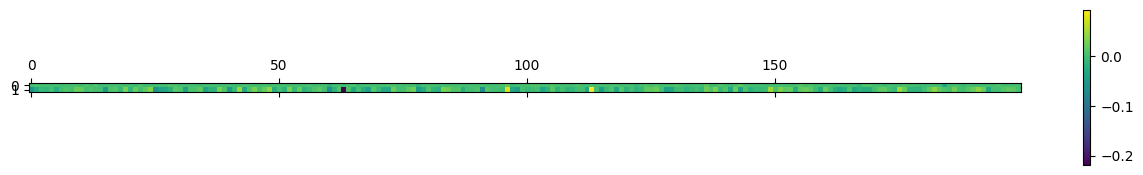

In [15]:
import matplotlib.pyplot as plt
plt.matshow((transformer_out_all[:,:s,:] - transformer_out_all_4)[0,:,:200].to(torch.float32).cpu().numpy())
plt.colorbar()


##### Depth Transformer

In [195]:
# For comparison sequential with streaming
output_depthtranformer = torch.cat([text_token_all.unsqueeze(1), audio_tokens_all], dim=1)
logits_all_4 = []
depformer_debug_all_4 = []
# Compute dep_former output via looping over audio codebooks

for s in range(transformer_out_all.shape[1]):
    logits_codebooks = []
    depformer_debug_ = []
    with torch.no_grad(), lm_gen.lm_model.depformer.streaming(1):
        for cb_index in range(8):
            transformer_out = transformer_out_all[:, s:s+1, :]
            code = output_depthtranformer[:, cb_index:cb_index+1, s:s+1]  # note we are not passing the last token
            logits, depformer_debug = lm_gen.lm_model.forward_depformer(depformer_cb_index=cb_index, sequence=code, transformer_out=transformer_out)
            logits_codebooks.append(logits.clone())
            depformer_debug_.append(depformer_debug)
    depformer_debug_all_4.append(torch.cat(depformer_debug_, dim=1))
    logits_all_4.append(torch.cat(logits_codebooks, 1))

depformer_debug_all_4 = torch.stack(depformer_debug_all_4, dim=2) # [B, K, S, dim]
logits_all_4 = torch.cat(logits_all_4, dim=2)  # [B, K, S, card]

print(torch.allclose(audio_logits_all.squeeze(3), logits_all_4))

True


In [238]:
# Now, via passing all codes directly
# For comparison sequential with streaming
output_depthtranformer = torch.cat([text_token_all.unsqueeze(1), audio_tokens_all], dim=1)
logits_all_3 = []
depformer_debug_all_3 = []
# Compute dep_former output via looping over audio codebooks

S = 4  # transformer_out_all.shape[1]
with torch.no_grad():
    for s in range(S):
        transformer_out = transformer_out_all[:, s:s+1, :]
        codes = input_depthtranformer[:, :, s:s+1]
        logits_codebooks, depformer_debug = lm_gen.lm_model.forward_depformer_all_codes(sequence=codes, transformer_out=transformer_out)

        logits_all_3.append(logits_codebooks.detach().clone())
        depformer_debug_all_3.append(depformer_debug)

depformer_debug_all_3 = torch.stack(depformer_debug_all_3, dim=2) # [B, K, S, dim]
logits_all_3 = torch.cat(logits_all_3, dim=2)  # [B, K, S, card]

print(torch.allclose(depformer_debug_all_4[:,:,:S], depformer_debug_all_3))
print(torch.allclose(audio_logits_all.squeeze(3)[:,:,:S], logits_all_3))

False
False


In [237]:
# The last codebook always differs
# And sometimes the fist one too
S = 4
K = 8

for s in range(S):
    for k in range(K):
        debug_ok = torch.allclose(depformer_debug_all_4[:,k,s], depformer_debug_all_3[:, k, s])
        logits_ok = torch.allclose(audio_logits_all.squeeze(3)[:,k,s], logits_all_3[:, k, s])
        if not debug_ok or not logits_ok:
            print(f"Not the same for s={s}, k={k}")
            print("debug", debug_ok, "logits", logits_ok)


Not the same for s=0, k=7
debug False logits False
Not the same for s=1, k=7
debug False logits False
Not the same for s=2, k=0
debug False logits False
Not the same for s=2, k=7
debug False logits False
Not the same for s=3, k=7
debug False logits False


##### Compare internal depform directly
For some reason last codebook gets different output

In [227]:

torch.manual_seed(42)
K = 8
depformer_input = torch.randn(1, K, 1024, device="cuda", dtype=torch.bfloat16)

dep_output_all_4 = []
with torch.no_grad(), lm_gen.lm_model.depformer.streaming(1):
    for k in range(K):
        depformer_input_ = depformer_input[:, k:k+1, :]
        dep_output = lm_gen.lm_model.depformer(depformer_input_)
        dep_output_all_4.append(dep_output)
    dep_output_all_4 = torch.cat(dep_output_all_4, dim=1)

with torch.no_grad():
    dep_output_all_3 = lm_gen.lm_model.depformer(depformer_input)

In [228]:
for k in range(K):
    print(k, torch.allclose(dep_output_all_4[:,k], dep_output_all_3[:,k]))

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 False


In [199]:
dep_output_all_4 - dep_output_all_3

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0156, -0.0010,  0.0156,  ..., -0.0469,  0.0156,  0.0703]]],
       device='cuda:0', dtype=torch.bfloat16)

#### Now pass in the whole sequence and codebooks all at once


In [242]:
S = 4  # output_depthtranformer.shape[2]


# Shape is [B, K, S]
# We passed into the tranformer [B, K, 1] for each item in sequence
output_depthtranformer = torch.cat([text_token_all.unsqueeze(1), audio_tokens_all], dim=1)
output_depthtranformer = output_depthtranformer[..., :S]
B, K, S = output_depthtranformer.shape
# Now, move sequence dim to the batch dim
# TODO(florian): test this for batch size > 1 !!!
output_depthtranformer_permuted = output_depthtranformer.permute(0, 2, 1)
output_depthtranformer_permuted = output_depthtranformer.view(B * S, K)
output_depthtranformer_permuted



with torch.no_grad():
    logits_all_6, depformer_debug_6 = lm_gen.lm_model.forward_depformer_all_codes(sequence=codes, transformer_out=transformer_out)


torch.Size([12, 9])

In [244]:
transformer_out.shape

torch.Size([1, 1, 4096])

In [241]:
output_depthtranformer.shape

torch.Size([1, 9, 12])

### Check positional embeddings

In [146]:
print(lm_gen.lm_model.depformer.positional_embedding)
print(lm_gen.lm_model.transformer.positional_embedding)

none
rope
